ICCAD 공모전 코드 이영석

In [1]:
## import layer
import qiskit_nature
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper,ParityMapper,QubitConverter
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator
from qiskit_aer.primitives import Sampler
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
import qiskit.providers
from qiskit import Aer,pulse, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
import time
import numpy as np
import matplotlib.pyplot as plt
from qiskit.opflow import I, X, Y, Z
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOpgit 
from qiskit.circuit.library import XXPlusYYGate
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import *
import pickle
from qiskit.primitives import BackendEstimator
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
import qiskit.providers.aer.noise as noise

In [2]:
## 파일경로는 저장한 경로에 따라 다름
with open(r'C:\Users\pad33\anaconda3\envs\Lee\NoiseModel\fakecairo.pkl', 'rb') as file:
    noise_model = pickle.load(file)

In [3]:
noise_model1 = noise.NoiseModel()
noise_modelreal = noise_model1.from_dict(noise_model)

c:\Users\pad33\anaconda3\envs\LEE\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  


In [53]:
seeds = 170
algorithm_globals.random_seed = seeds
seed_transpiler = seeds
iterations = 125
shot = 13235
simulator = Aer.get_backend('aer_simulator_statevector')

In [5]:
## 파일 경로는 저장한 경로에 따라 다름
file_path = r'C:\Users\pad33\Downloads\OHhamiltonian.txt'

try:
    # 파일 열기 (기본적으로 읽기 모드인 'r'을 사용)
    with open(file_path, 'r') as file:
        # 파일 내용 읽기
        file_contents = file.read()
        
        # 파일 내용 출력
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"파일을 읽는 동안 오류가 발생했습니다: {str(e)}")

In [25]:
# 파일 해밀토니안 추출
import random
def extract(text):
    global P_string
    temp = 0*(I^12)
    lines = text.split('\n')
    for line in lines:
        P_string = 0*I
        value = ""
        index = 0
        I_index = 0
        for word in line:
            if word != "*" and index==0:
                value+=word
            else:
                index +=1
            if index >=1:
                if I_index == 0:
                    if word == "I":
                        P_string += I
                        I_index+=1
                        
                    elif word == "X":
                        P_string += X
                        I_index+=1
                        
                    elif word == "Y":
                        P_string += Y
                        I_index+=1
                        
                    elif word == "Z":
                        P_string += Z
                        I_index+=1
                    else:
                        I_index+=0
                else:
                    if word == "I":
                        P_string = P_string^I
                        I_index+=1
                    elif word == "X":
                        P_string = P_string^X
                        I_index+=1
                    elif word == "Y":
                        P_string = P_string^Y
                        I_index+=1
                    elif word == "Z":
                        P_string = P_string^Z
        value = value.replace(" ", "")
        value = float(value)        
        temp = (temp) + ((P_string)*(value))
    return temp.reduce()
## 안사츠 구성(HV)
def ansatz(hamiltonian, num_qubits=0,reps=1):
    ham = hamiltonian
    para = ParameterVector('theta',len(ham)*reps+1)
    if num_qubits!=0:
        num = num_qubits
    else:
        num = ham.num_qubits
    qc = QuantumCircuit(num)
    for i in range(5):
        qc.rx(para[0],i)
    index = 1
    for rep in range(reps):
        for ham_part in ham:
            qc.append(PauliEvolutionGate(ham_part,para[index]),qc.qubits)
            index +=1
    return qc
## 안사츠 구성(NP)
def np_ansatz(hamiltonian, num_qubits=0,reps=1):
    ham = hamiltonian
    para = ParameterVector('theta',len(ham)*reps*2)
    para1 =  ParameterVector('theta1',len(ham)*reps*2)
    if num_qubits!=0:
        num = num_qubits
    else:
        num = ham.num_qubits
    para3 = ParameterVector('theta3',len(ham))
    qc = QuantumCircuit(num)
    list = random.sample([i for i in [0,1,2,3,4,6,7,8]],  8)
    #이상적인 값
    list = [i for i in range(0,8)]
    #list = [i for i in range(4,12)]
    list.sort(reverse=True)
    list_else = [i for i in range(0,num)]
    for i in list:
        list_else.remove(i)
    for i in list:
        qc.x(i)
    for i in list_else:
        qc.i(i)
    index = 0
    index1 = 0
    index2 = 0
    for i in list:
        for j in list_else:
            qc.append(XXPlusYYGate(para[index],para1[index1]),[i,j])
            index+=1
    for i in range(num):
        qc.rz(para3[index2],i)
        index2+=1
    for j in range(reps-1):
        for i in range(num-1):
            qc.append(XXPlusYYGate(para[index]),[i,i+1])
            qc.cp(para1[index1],i,i+1)
            index+=1
            index1+=1
    return qc

여기서부턴 hamiltonian group화

In [7]:
def Graph_made(Ham):
    num=len(Ham)
    Mat = []
    for i in range(num):
        line = []
        for j in range(num):
            if i==j:
                input = 0
            else:
                if is_single_commute(Ham[i],Ham[j]):
                    input = 1
                else:
                    input = 0
            line.append(input)
        Mat.append(line)
    return Mat

In [8]:
def is_single_commute(Ham1, Ham2):
    str1 = str(Ham1.primitive.paulis[0])
    str2 = str(Ham2.primitive.paulis[0])
    for i in range(len(str1)):
        if str1[i] != 'I' and str2[i] != 'I':
            if str1[i] != str2[i]:
                return False
    return True


In [9]:
# 해밀토니안과 안사츠 할당
hamiltonian = extract(file_contents)
ansatz1 = np_ansatz(hamiltonian,reps=2)

In [10]:
import networkx as nx
from collections import defaultdict

In [11]:
def make_edge_numbers(matrix):
  '''
    matrix를 받아서, edge number dict 생성
  '''
  size = len(matrix)
  result = defaultdict(list)
  count = 0
  for i in range(size):
    for j in range(i, size):
      if matrix[i][j] == 1:
        result[count] = [i, j]
        count += 1
  return result

In [12]:
def group_ham(hamiltonian):
    result = []
    Mat = Graph_made(hamiltonian)
    G = nx.Graph()
    edge_dic = make_edge_numbers(Mat)
    # 정점 추가
    for i in range(len(Mat)):
        G.add_node(i)

    # 엣지 추가
    for i in range(len(Mat)):
        for j in range(i + 1, len(Mat)):
            if Mat[i][j] == 1:
                G.add_edge(i, j)
    C = nx.complement(G)
    groups = nx.coloring.greedy_color(C, strategy="largest_first")
    num_groups = len(set(groups.values()))
    for i in range(num_groups):
        temp = []
        for term, group_id in groups.items():
            if group_id == i:
                temp.append(hamiltonian[term])
        result.append(temp)
    return result

In [41]:
from qiskit.primitives import BackendSampler
backend = FakeMontreal()
def is_single_commute(Ham1, Ham2):
    str1 = str(Ham1.primitive.paulis[0])
    str2 = str(Ham2.primitive.paulis[0])
    for i in range(len(str1)):
        if str1[i] != 'I' and str2[i] != 'I':
            if str1[i] != str2[i]:
                return False
    return True
def Opeartation_string(PauliOPS):
    result = 'I'*PauliOPS[0].num_qubits
    result = list(result)
    for OP in PauliOPS:
        temp = str(OP.primitive.paulis[0])
        index = 0
        for word in temp:
            if word !='I' and word !='Z':
                result[index] = word
            index+=1
    return result
def operation_circ(ansatz,g_ham,para=None):
    result_list = []
    ansatz_temp = ansatz.copy()
    temp_index = 0
    for i in ansatz_temp.parameters:
        ansatz_temp = ansatz_temp.bind_parameters({i:para[temp_index]})
        temp_index+=1
    for part_ham in g_ham:
        temp = ansatz_temp.copy()
        temp.barrier(temp.qubits)
        op_str = Opeartation_string(part_ham)
        for i in range(len(op_str)):
            if op_str[-(i+1)]=='X':
                temp.h(i)
            elif op_str[-(i+1)]=='Y':
                temp.h(i)
                temp.s(i)
                temp.z(i)
        if temp.num_clbits == 0:
            temp.measure_all()
        result_list.append(temp)
    return result_list

def expectation_value_circ_noisy(para,ansatz,g_ham):
    circ_list = operation_circ(ansatz,g_ham,para)
    sampler = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU',
        'noise_model': noise_modelreal
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler,
        'optimization_level':0
    }
    )
    job = sampler.run(circ_list)
    result_list = job.result()
    index = 0
    exp_value = 0
    g_str = []
    for i in range(len(g_ham)):
        temp_list=[]
        for part_of_group in g_ham[i]:
            P_str = str(part_of_group.primitive.paulis[0])
            coeffs = part_of_group.coeffs
            temp_list.append([P_str,coeffs])
        g_str.append(temp_list)
    for index in range(len(g_ham)):
        for sampler_result in result_list.quasi_dists[index].keys():
            prob = result_list.quasi_dists[index][sampler_result]
            result_str = bin(sampler_result)
            result_str = result_str[2:]
            for part_of_group in g_str[index]:
                res = 1
                coeffs = part_of_group[1]
                P_str = part_of_group[0]
                for P in range(len(result_str)):
                    if P_str[-(P+1)]!='I' and result_str[-(P+1)]=='1':
                        res*=-1
                exp_value+=coeffs*res*prob
    cb(exp_value[0].real,para)
    return exp_value[0].real


counts = []
values = []
paras = []
itter = [0]
def cb(exp_value, para):
    print("itteration count : ",itter[0])
    counts.append(itter[0])
    values.append(exp_value)
    print("E_val : " ,values[-1])
    paras.append(para)
    itter[0] += 1     
def expectation_value_circ(para,ansatz,g_ham):
    circ_list = operation_circ(ansatz,g_ham,para)
    sampler = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU'
        #'noise_model': noise_modelreal
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler
    }
    )
    job = sampler.run(circ_list)
    result_list = job.result()
    index = 0
    exp_value = 0
    g_str = []
    for i in range(len(g_ham)):
        temp_list=[]
        for part_of_group in g_ham[i]:
            P_str = str(part_of_group.primitive.paulis[0])
            coeffs = part_of_group.coeffs
            temp_list.append([P_str,coeffs])
        g_str.append(temp_list)
    for index in range(len(g_ham)):
        for sampler_result in result_list.quasi_dists[index].keys():
            prob = result_list.quasi_dists[index][sampler_result]
            result_str = bin(sampler_result)
            result_str = result_str[2:]
            for part_of_group in g_str[index]:
                res = 1
                coeffs = part_of_group[1]
                P_str = part_of_group[0]
                for P in range(len(result_str)):
                    if P_str[-(P+1)]!='I' and result_str[-(P+1)]=='1':
                        res*=-1
                exp_value+=coeffs*res*prob
    cb(exp_value[0].real,para)
    return exp_value[0].real
def get_statevector(qc, paras):
    index = 0
    for i in qc.parameters:
        qc = qc.bind_parameters({i:paras[index]})
        index+=1
    qc.save_statevector()
    job = execute(qc, simulator)
    job_result = job.result()
    res = np.array(job_result.get_statevector())
    return res

In [31]:
g_ham = group_ham(hamiltonian)

In [26]:
ansatz1 = np_ansatz(hamiltonian,reps=2)

In [16]:

from scipy.optimize import curve_fit
def Foward_diffrentiaion(list, h):
    if len(list) != 5:
        print("lenth is not proper")
        raise NotImplementedError
    else:
        return (1/12*list[0]-2/3*list[1]-0*list[2]+2/3*list[3]-1/12*list[4])/h


def Foward_diffrentiaion_SC(list, h):
    if len(list) != 5:
        print("lenth is not proper")
        raise NotImplementedError
    else:
        return (-1/12*list[0]+4/3*list[1]-5/2*list[2]+4/3*list[3]-1/12*list[4])/h

def my_function(x, a, b, c):
    return a * b**(x)+ c*(1-b**(x))

def fit_curve_exp(my_function, x, y):
    b = -Foward_diffrentiaion_SC(y, 1)/Foward_diffrentiaion(y, 1)
    a = -Foward_diffrentiaion(y, 1)/b
    c = y[2]-a
    value1, cov1 = curve_fit(my_function, x, y,
                             maxfev=20000, p0=[a, b, y[2]-a])
    e = Foward_diffrentiaion_SC(y, 1)/Foward_diffrentiaion(y, 1)
    d = -Foward_diffrentiaion(y, 1)/e
    f = y[2]-d
    value2, cov2 = curve_fit(my_function, x, y,
                             maxfev=20000, p0=[d, e, y[2]-f])
    if np.sum(cov1**2) > np.sum(cov2**2):
        value = value2
    else:
        value = value1
    return value
def Foward_diffrentiaion4(list, h):
    if len(list) != 3:
        print("lenth is not proper")
        raise NotImplementedError
    else:
        return (-3/2*list[0]+2*list[1]-1/2*list[2])/h

def Foward_diffrentiaion_SC4(list, h):
    if len(list) != 4:
        print("lenth is not proper")
        raise NotImplementedError
    else:
        return (2*list[0]-5*list[1]+4*list[2]-1*list[3])/h
    
def fit_curve_exp_3(my_function, x, y, depth=1):
    #b = -Foward_diffrentiaion_SC4(temp, 1)/Foward_diffrentiaion4(temp1, 1)
    if depth == 1:
        b = 0.93
    else:
        b = 0.999**depth
    a = y[0]
    c = (y[-1]-a*b**5)/(1-b**5)
    if a>c:
    #c = 4
        value1, cov1 = curve_fit(my_function, x, y,
                                maxfev=20000, p0=[a, b, c], bounds = ([a,b-0.2,c-100],[10000,1,c+100]))
    else:
        value1, cov1 = curve_fit(my_function, x, y,
                                maxfev=20000, p0=[a, b, c], bounds = ([-10000,b-0.2,c-100],[a,1,c+100]))
    temp = y[0]
    value,cov1 = curve_fit(my_function,x[0],temp,maxfev=20000,p0=value1,bounds = ([value1[0]-10,value1[1]-0.001,value1[2]-0.001],[value1[0]+10,value1[1]+0.001,value1[2]+0.001]))
    print(value)
    return value

In [17]:
def extra_polate(qc,reps):
    index = 0
    temp1 = qc.qasm()
    temp = temp1.split('\n')
    temp_temp = []
    for i in temp:
        temp = i.split(' ')
        if temp[0]=='cx':
            temp_temp.append(i)
            index +=1
            for j in range(reps):
                temp_temp.append(i)
                temp_temp.append(i)
        elif temp[0]=='ecr':
            temp_temp.append(i)
            index +=1
            for j in range(reps):
                temp_temp.append(i)
                temp_temp.append(i)
        else:
            temp_temp.append(i)
    temp_temp_conbine = '\n'.join(temp_temp)
    qc_result = QuantumCircuit(qc.num_qubits)
    qc_result = qc_result.from_qasm_str(temp_temp_conbine)
    return [qc_result,index]

In [18]:
def extra_polate1(qc,reps):
    gate = qc.to_gate()
    qc_result = QuantumCircuit(qc.num_qubits)
    qc_result.append(gate,qc.qubits)
    for i in range(reps*2):
        qc_result.append(gate,qc.qubits)
    qc_result = transpile(qc_result,basis_gates=['x', 'sx', 'id', 'cx','rz'], optimization_level=0)
    return qc_result

In [19]:
def expectation_value_ZNE(para,ansatz,g_ham):
    ansatz_list = []
    for i in range(5):
        ansatz_list.append(extra_polate(ansatz,i)[0])
    depth=extra_polate(ansatz,i)[1]
    result_list = []
    for i in range(5):
        result_list.append(expectation_value_circ_noisy(para,ansatz_list[i],g_ham))
    x = [i*2+1 for i in range(5)]
    fit_curve = fit_curve_exp_3(my_function,x,result_list,depth)
    plt.plot(x,result_list,'bo',color ='r')
    cal = [my_function(x[i],*fit_curve) for i in range(5)]
    plt.plot(x,cal)
    res = my_function(0,* fit_curve)
    return res

In [20]:
"""def expectation_value_ZNE1(para,ansatz,g_ham):
    ansatz_list = []
    for i in range(5):
        ansatz_list.append(extra_polate1(ansatz,i))
    result_list = []
    for i in range(5):
        result_list.append(expectation_value_circ_noisy(para,ansatz_list[i],g_ham))
    x = [i for i in range(5)]
    fit_curve = fit_curve_exp_3(my_function,x,result_list)
    plt.plot(x,result_list,'bo')
    cal = [my_function(x[i],*fit_curve) for i in range(5)]
    plt.plot(x,cal)
    res = my_function(-0.5,* fit_curve)
    return res"""

"def expectation_value_ZNE1(para,ansatz,g_ham):\n    ansatz_list = []\n    for i in range(5):\n        ansatz_list.append(extra_polate1(ansatz,i))\n    result_list = []\n    for i in range(5):\n        result_list.append(expectation_value_circ_noisy(para,ansatz_list[i],g_ham))\n    x = [i for i in range(5)]\n    fit_curve = fit_curve_exp_3(my_function,x,result_list)\n    plt.plot(x,result_list,'bo')\n    cal = [my_function(x[i],*fit_curve) for i in range(5)]\n    plt.plot(x,cal)\n    res = my_function(-0.5,* fit_curve)\n    return res"

In [21]:
"""def expectation_value_ZNE2(para,ansatz,g_ham):
    ansatz_list = []
    for i in range(5):
        ansatz_list.append(extra_polate(ansatz,i))
    result_list = []
    for i in range(5):
        result_list.append(expectation_value_circ_noisy(para,ansatz_list[i],g_ham))
    x = [ansatz_list[i].depth()/(ansatz_list[0].depth()*2) for i in range(5)]
    fit_curve = fit_curve_exp_3(my_function,x,result_list)
    plt.plot(x,result_list,'bo',color ='r')
    cal = [my_function(x[i],*fit_curve) for i in range(5)]
    plt.plot(x,cal)
    res = my_function(0,* fit_curve)
    return res"""

"def expectation_value_ZNE2(para,ansatz,g_ham):\n    ansatz_list = []\n    for i in range(5):\n        ansatz_list.append(extra_polate(ansatz,i))\n    result_list = []\n    for i in range(5):\n        result_list.append(expectation_value_circ_noisy(para,ansatz_list[i],g_ham))\n    x = [ansatz_list[i].depth()/(ansatz_list[0].depth()*2) for i in range(5)]\n    fit_curve = fit_curve_exp_3(my_function,x,result_list)\n    plt.plot(x,result_list,'bo',color ='r')\n    cal = [my_function(x[i],*fit_curve) for i in range(5)]\n    plt.plot(x,cal)\n    res = my_function(0,* fit_curve)\n    return res"

여기서부턴 ansatz 계산

In [22]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.fake_provider import FakeCairoV2
solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

In [28]:
## 콜백함수 설정과 안사츠 transpile
counts = []
values = []
paras = []
itter = [0]
system_model = FakeMontreal()
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    paras.append(parameters)
    itter[0] += 1
    print("itteration count : ",itter[0])
    print("E_val : " ,values[-1])
ansatz1 = ansatz1.decompose(reps=1)
ansatz1 = transpile(ansatz1, basis_gates=['x', 'sx', 'id', 'cx','rz'], optimization_level=2)

In [32]:
## VQE 가동(noise model 설정으로 이상과 noisy변환 가능)
counts = []
values = []
paras = []
itter = [0]
estimator = Estimator(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU'
        #'noise_model': noise_modelreal
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler
    }
)
vqe_solver = VQE(estimator, ansatz1, COBYLA(maxiter=100,rhobeg=np.pi/2), callback=store_intermediate_result)
vqe_solver.initial_point = [0.0] * ansatz1.num_parameters
result = vqe_solver.compute_minimum_eigenvalue(operator=hamiltonian)
print(f"VQE on Aer qasm simulator (noiseless): {result.eigenvalue.real:.5f}")

itteration count :  1
E_val :  -77.83504988268177
itteration count :  2
E_val :  -77.83504988268177
itteration count :  3
E_val :  -77.83504988268177
itteration count :  4
E_val :  -77.83504988268177
itteration count :  5
E_val :  -77.83504988268177
itteration count :  6
E_val :  -77.83504988268177
itteration count :  7
E_val :  -77.83504988268177
itteration count :  8
E_val :  -77.83504988268177
itteration count :  9
E_val :  -77.83504988268177
itteration count :  10
E_val :  -77.83504988268177
itteration count :  11
E_val :  -77.83504988268177
itteration count :  12
E_val :  -77.83504988268177
itteration count :  13
E_val :  -77.83504988268177
itteration count :  14
E_val :  -77.83504988268177
itteration count :  15
E_val :  -77.83504988268177
itteration count :  16
E_val :  -77.83504988268177
itteration count :  17
E_val :  -77.83504988268177
itteration count :  18
E_val :  -77.83504988268177
itteration count :  19
E_val :  -77.83504988268177
itteration count :  20
E_val :  -77.8350

Text(0.5, 1.0, 'Convergence with no noise Estimator')

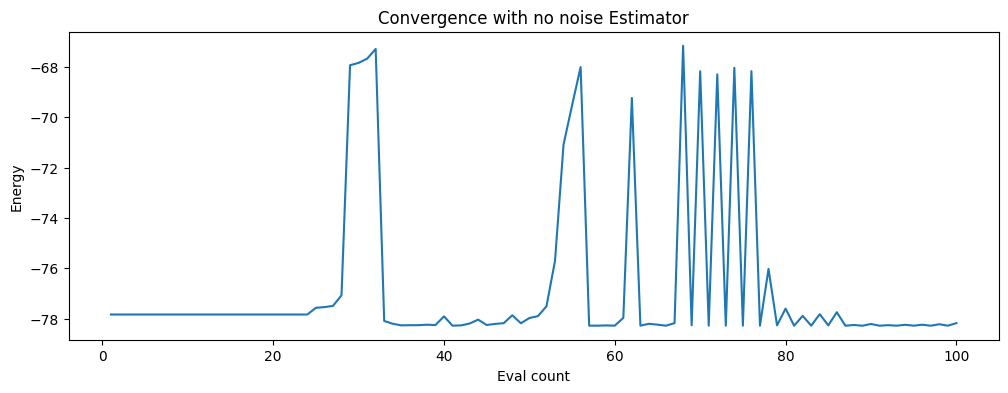

In [33]:
## plot
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise Estimator")

In [48]:
### 코드 매우 오래 걸립니다(1~2시간)
from qiskit.providers.aer import AerSimulator
backend_sim = AerSimulator.from_backend(FakeMontreal())
estimator = BackendEstimator(FakeMontreal())
qc = ansatz1
index = 0
qc = qc.bind_parameters(result.optimal_parameters)
job = estimator.run(qc,hamiltonian)
result1 = job.result()
print(result1)

[-77.5881214    0.88966645 -50.14981372]


c:\Users\pad33\anaconda3\envs\LEE\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\Users\pad33\anaconda3\envs\LEE\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


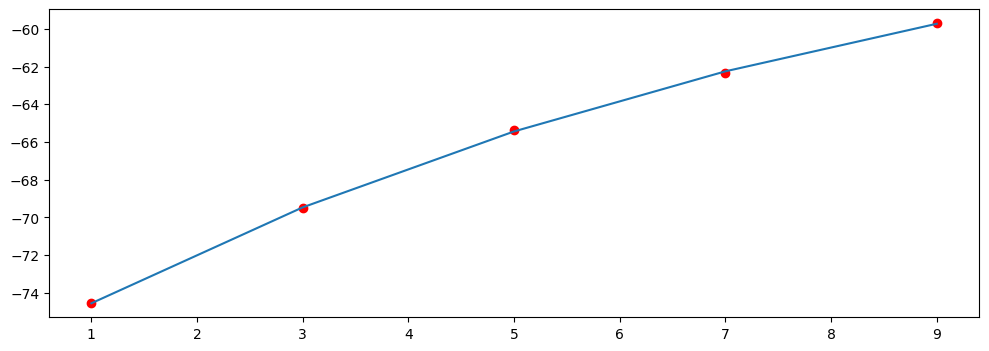

In [34]:
### 코드 매우 오래 걸립니다(5~6시간)(shot =6000)(RES)
## ZNE 결과
qc = ansatz1.copy()
qc = qc.bind_parameters(result.optimal_parameters)
res = expectation_value_ZNE([0],qc,g_ham)
print(res)

itteration count :  0
E_val :  -74.1172148872553
itteration count :  1
E_val :  -68.95943827547651
itteration count :  2
E_val :  -64.87119068654137
itteration count :  3
E_val :  -61.795283016545625
itteration count :  4
E_val :  -59.279916946254104
[-77.22500562   0.8835678  -50.53315549]
-77.2250056179573


c:\Users\pad33\anaconda3\envs\LEE\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\Users\pad33\anaconda3\envs\LEE\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


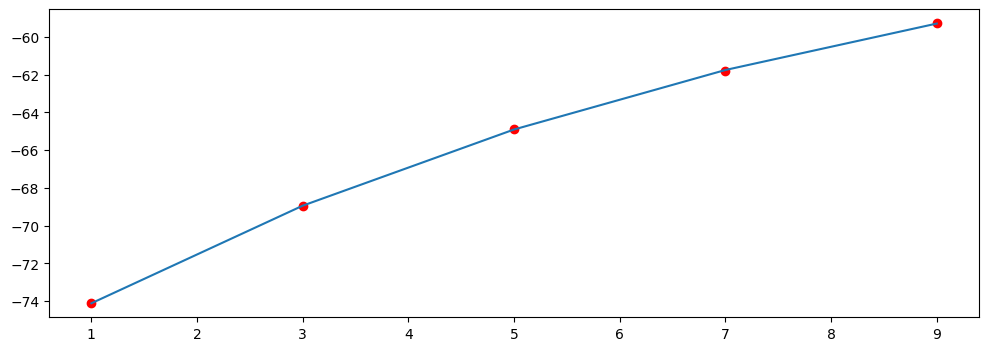

In [42]:
### 코드 매우 오래 걸립니다(5~6시간)(shot =6000)(REF)
## ZNE 결과
qc = ansatz1.copy()
for i in qc.parameters:
    qc= qc.bind_parameters({i:0})
res = expectation_value_ZNE([0],qc,g_ham)
print(res)

In [58]:
### 코드 매우 오래 걸립니다(5~6시간)(shot =13000)(RES)
## ZNE 결과
qc = ansatz1.copy()
qc = qc.bind_parameters(result.optimal_parameters)
res = expectation_value_ZNE([0],qc,g_ham)
print(res)

itteration count :  8
E_val :  -74.43483019531655
itteration count :  9
E_val :  -69.55891856232489
itteration count :  10
E_val :  -65.41977687728712
itteration count :  11
E_val :  -62.17761387386344


In [ ]:
### 코드 매우 오래 걸립니다(5~6시간)(shot =13000)(REF)
## ZNE 결과
qc = ansatz1.copy()
for i in qc.parameters:
    qc= qc.bind_parameters({i:0})
res = expectation_value_ZNE([0],qc,g_ham)
print(res)

In [54]:
ref = expectation_value_circ([0],qc,g_ham)

itteration count :  7
E_val :  -77.82486566010391


In [55]:
REM = ref - res

In [35]:
## duration
with pulse.build(FakeMontreal()) as my_program1:
  pulse.call(ansatz1)
my_program1.duration

239584

In [ ]:
## noise estimator 계산 (오래걸립니다)
counts = []
values = []
itter = [0]
estimator = BackendEstimator(FakeMontreal())
print("VQE start")
vqe_solver = VQE(estimator, ansatz1, COBYLA(maxiter=100), callback=store_intermediate_result)
vqe_solver.initial_point = [1.0] * ansatz1.num_parameters
result = vqe_solver.compute_minimum_eigenvalue(operator=hamiltonian)
print(f"VQE on Aer qasm simulator (noise_less): {result.eigenvalue.real:.5f}")

Sampler 이용한 계산

In [ ]:
import pylab
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

In [19]:
## noise sampler 계산 (오래걸립니다)
backend = FakeMontreal()
from scipy.optimize import minimize
Init_pt = [0]*ansatz1.num_parameters
Optimum = minimize(expectation_value_circ_noisy,Init_pt,args=(ansatz1,g_ham),method='COBYLA',options={"maxiter":50,"rhobeg":np.pi/2})

itteration count :  0
E_val :  -55.2937352072334
itteration count :  1
E_val :  -55.2937352072334
itteration count :  2
E_val :  -55.29377452321162
itteration count :  3
E_val :  -55.293385647993574
itteration count :  4
E_val :  -55.29386386528341
itteration count :  5
E_val :  -55.293742187831356
itteration count :  6
E_val :  -55.29386386528341
itteration count :  7
E_val :  -55.29386386528341
itteration count :  8
E_val :  -55.29386386528341
itteration count :  9
E_val :  -55.29386386528341
itteration count :  10
E_val :  -55.29386386528341
itteration count :  11
E_val :  -55.29386386528341
itteration count :  12
E_val :  -55.29386386528341
itteration count :  13
E_val :  -55.29386386528341
itteration count :  14
E_val :  -65.71739916822656
itteration count :  15
E_val :  -65.99581550625413
itteration count :  16
E_val :  -66.01387618997187
itteration count :  17
E_val :  -66.09906239193413
itteration count :  18
E_val :  -70.84019029033173
itteration count :  19
E_val :  -71.18849

In [85]:
backend = FakeMontreal()
from scipy.optimize import minimize
Init_pt = [0]*ansatz1.num_parameters
Optimum = minimize(expectation_value_circ_noisy,Init_pt,args=(ansatz1,g_ham),method='COBYLA',options={"maxiter":50,"rhobeg":np.pi/2})

itteration count :  1
E_val :  -56.61741184866557
itteration count :  2
E_val :  -55.77738500278359
itteration count :  3
E_val :  -56.52535461876576
itteration count :  4
E_val :  -56.84959462202712
itteration count :  5
E_val :  -56.28968111465066
itteration count :  6
E_val :  -57.04837043109397
itteration count :  7
E_val :  -55.89144515715579
itteration count :  8
E_val :  -56.61155534594939
itteration count :  9
E_val :  -57.27744071221032
itteration count :  10
E_val :  -56.69868946016314
itteration count :  11
E_val :  -57.383275523919195
itteration count :  12
E_val :  -57.327942462399875
itteration count :  13
E_val :  -57.200020210917906
itteration count :  14
E_val :  -64.26848238154665
itteration count :  15
E_val :  -65.91563342255297
itteration count :  16
E_val :  -64.35821195246118
itteration count :  17
E_val :  -65.8927793047831
itteration count :  18
E_val :  -67.999543337383
itteration count :  19
E_val :  -68.88767279115102
itteration count :  20
E_val :  -67.8388

In [86]:
sam_counts_noisy = counts.copy()
sam_values_noisy = values.copy()
sam_paras_noisy = paras.copy()
sam_itter_noisy = itter.copy()

Text(0.5, 1.0, 'Convergence with noise')

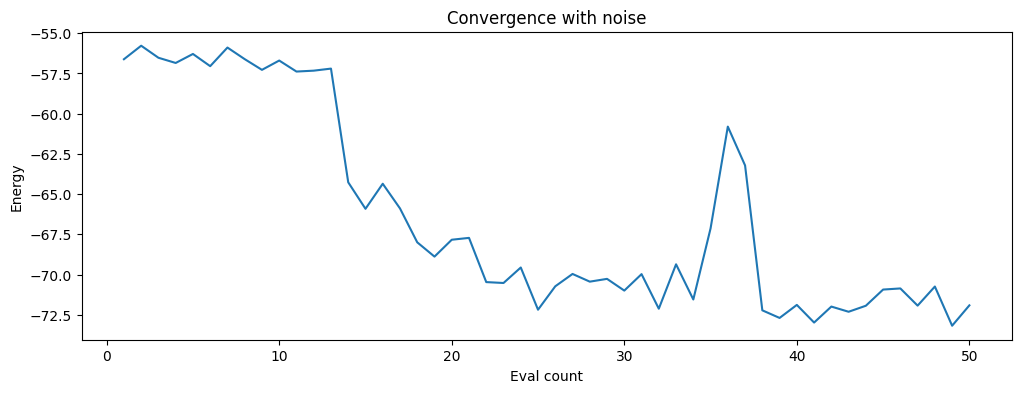

In [90]:
import pylab
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(sam_counts_noisy[1:] , sam_values_noisy[1:])
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with noise")

In [88]:
sam_values_noisy

[-2.611912284951058,
 -56.61741184866557,
 -55.77738500278359,
 -56.52535461876576,
 -56.84959462202712,
 -56.28968111465066,
 -57.04837043109397,
 -55.89144515715579,
 -56.61155534594939,
 -57.27744071221032,
 -56.69868946016314,
 -57.383275523919195,
 -57.327942462399875,
 -57.200020210917906,
 -64.26848238154665,
 -65.91563342255297,
 -64.35821195246118,
 -65.8927793047831,
 -67.999543337383,
 -68.88767279115102,
 -67.83880786932023,
 -67.72353207847998,
 -70.47240818558001,
 -70.52767544459088,
 -69.56538730830124,
 -72.18936219123258,
 -70.7330382345774,
 -69.96591406780468,
 -70.44433960239134,
 -70.27161546994283,
 -71.000553543918,
 -69.9769636235308,
 -72.12617218603694,
 -69.36641791870407,
 -71.55364246791036,
 -67.13396247505936,
 -60.80665983025683,
 -63.21916248223054,
 -72.22713059649435,
 -72.70027729240299,
 -71.89042758116386,
 -72.9873104677945,
 -71.99383389170818,
 -72.31607707663915,
 -71.94229454784599,
 -70.93601546229905,
 -70.86667138171701,
 -71.9348818581856